# Problem Statement:
Nowadays, traffic is a major issue for everyone, and it is a source of stress for anyone
who has to deal with it on a daily basis. The growth of the population delays traffic and
makes it worse day by day. The settlement of modern civilization looks at it, but it is
unable to act in such a way as to protect people. We can watch traffic, collect data, and
anticipate the next and subsequent observations using a variety of approaches and
patterns. The observation agency then makes observations, which are then required out
and predictions are made. Being stuck in a cosmopolitan city's traffic is the most
common occurrence in one's life.
The goal of this project is to build a prediction model using multiple machine learning
techniques and to use a template to document the end-to-end stages. We're trying to
forecast the value of a continuous variable with the Metro Interstate Traffic Volume
dataset, which is a regression issue.



# Attribute Information:

* holiday - Categorical US National holidays plus regional holiday, Minnesota State Fair
* temp Numeric Average temp in kelvin
* rain_1h - Numeric Amount in mm of rain that occurred in the hour
* snow_1h - Numeric Amount in mm of snow that occurred in the hour
* clouds_all - Numeric Percentage of cloud cover
* weather_main - Categorical Short textual description of the current weather
* weather_description - Categorical Longer textual description of the current weather
* date_time - DateTime Hour of the data collected in local CST time
* traffic_volume - Numeric Hourly I-94 ATR 301 reported westbound traffic volume

You can get the dataset from this link:
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

# Importing required libraries

In [1]:
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from catboost import CatBoostRegressor # This should now work after install
from xgboost import XGBRegressor
import pickle
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',10)
%matplotlib inline


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install cassandra-driver


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Read dataset

In [3]:
# prompt: READ

import pandas as pd
df = pd.read_csv(R"E:\BIA\Metro_Interstate_Traffic_Volume.csv")


In [4]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
df.shape

(48204, 9)

## Glimpse data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [7]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [8]:
df.describe(include='object')

,holiday,weather_main,weather_description,date_time
count,61,48204,48204,48204
unique,11,11,38,40575
top,Labor Day,Clouds,sky is clear,2013-05-19 10:00:00
freq,7,15164,11665,6


# Checking missing, duplicate values and datatypes

In [9]:
df.isnull().sum()

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

#### There is no missing value at all

In [10]:
df.duplicated().sum()

17

#### 17 rows are duplicated, we should remove them.

In [11]:
df.drop_duplicates(inplace=True)

### Let's check datatypes of each column

In [12]:
df.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

"date_time" column should be with **datetime** datatype!

In [13]:
df['date_time']=pd.to_datetime(df['date_time'])

In [14]:
df['snow_1h']=df['snow_1h'].astype('float64')

In [15]:
df['temp']=df['temp'].astype('float64')

In [16]:
df.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object

It seems all datatypes are correct now!

In [17]:
df.shape

(48187, 9)

In [18]:
df['date_time'].min(),df['date_time'].max()

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

Timeframe in the dataset is between 2012-10-02 09:00 and 2018-09-30 23:00.

# Exploratory Data Analysis

In [19]:
df.sort_values(by=['date_time'],inplace=True)

<Axes: title={'center': 'Special day counts'}, xlabel='count', ylabel='holiday'>

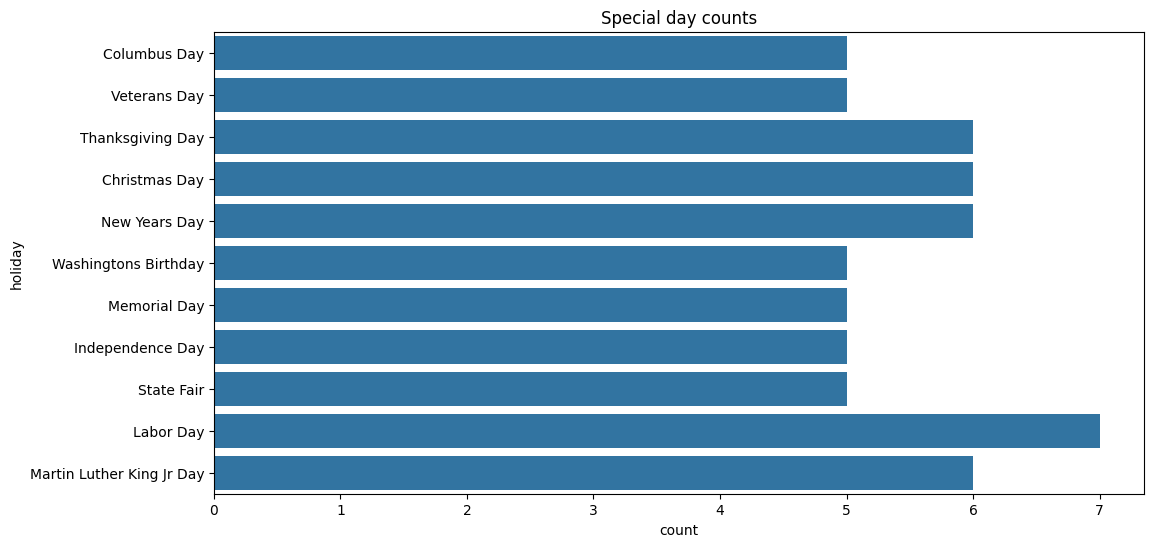

In [20]:
plt.figure(figsize=(12,6))
plt.title('Special day counts')
sns.countplot(y='holiday',data=df)

It is difficult to see counts of special days as there are far more non holiday days. Let's exclude "None" to see the number of all special days clearly in the dataset.

<Axes: title={'center': 'Special day counts'}, xlabel='count', ylabel='holiday'>

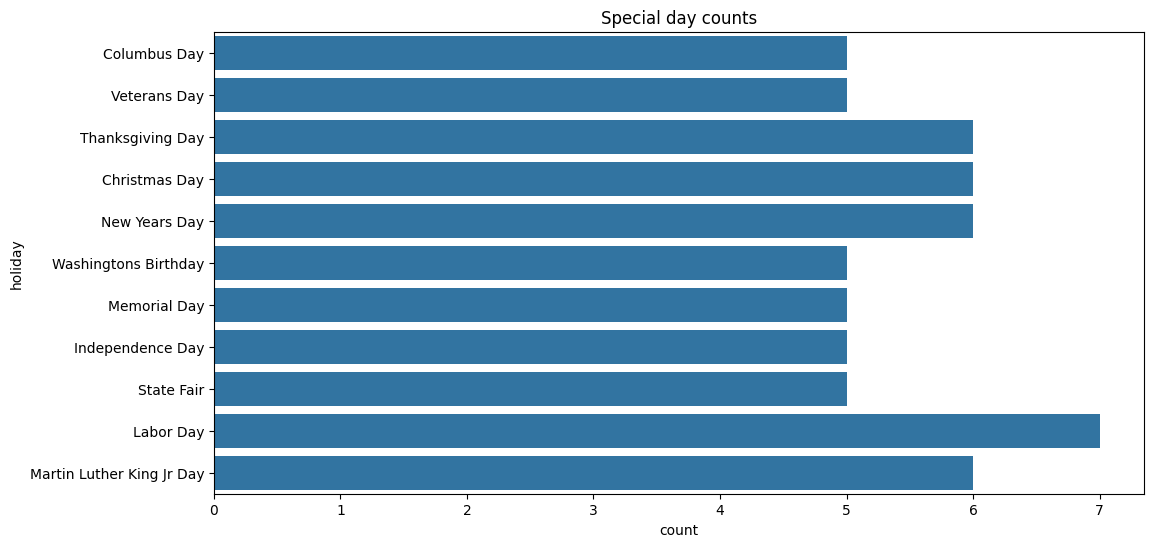

In [21]:
plt.figure(figsize=(12,6))
plt.title('Special day counts')
sns.countplot(y='holiday',data=df[df['holiday']!='None'])

Let's analyze the frequency of weather condition (weather_main)!

<Axes: xlabel='count', ylabel='weather_main'>

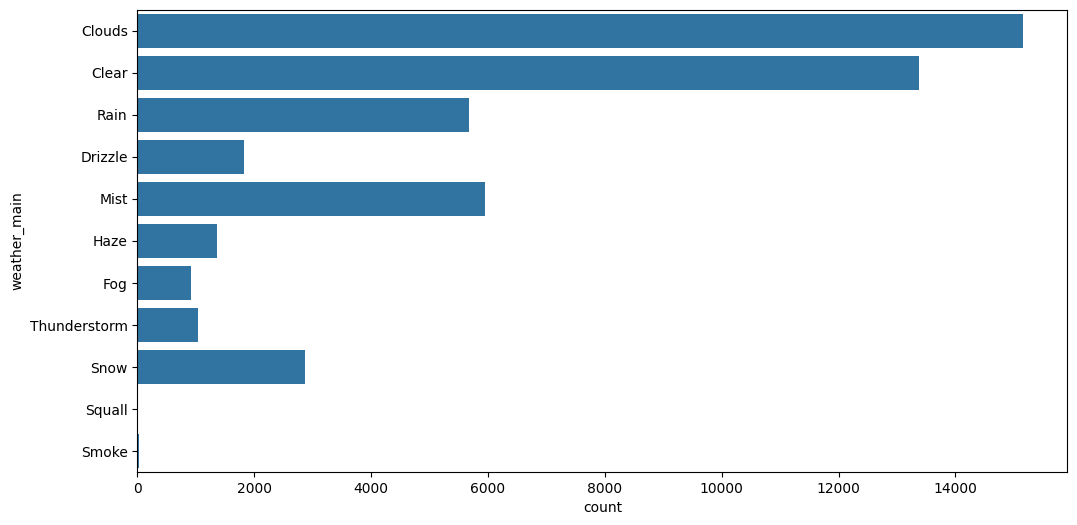

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(y='weather_main',data=df)

In [23]:
df['weather_main'].value_counts()

weather_main
Clouds          15158
Clear           13384
Mist             5949
Rain             5672
Snow             2875
Drizzle          1820
Haze             1360
Thunderstorm     1033
Fog               912
Smoke              20
Squall              4
Name: count, dtype: int64

There are 11 weather_main unique values. It is okay to keep all of them in the dataset.

<Axes: xlabel='count', ylabel='weather_description'>

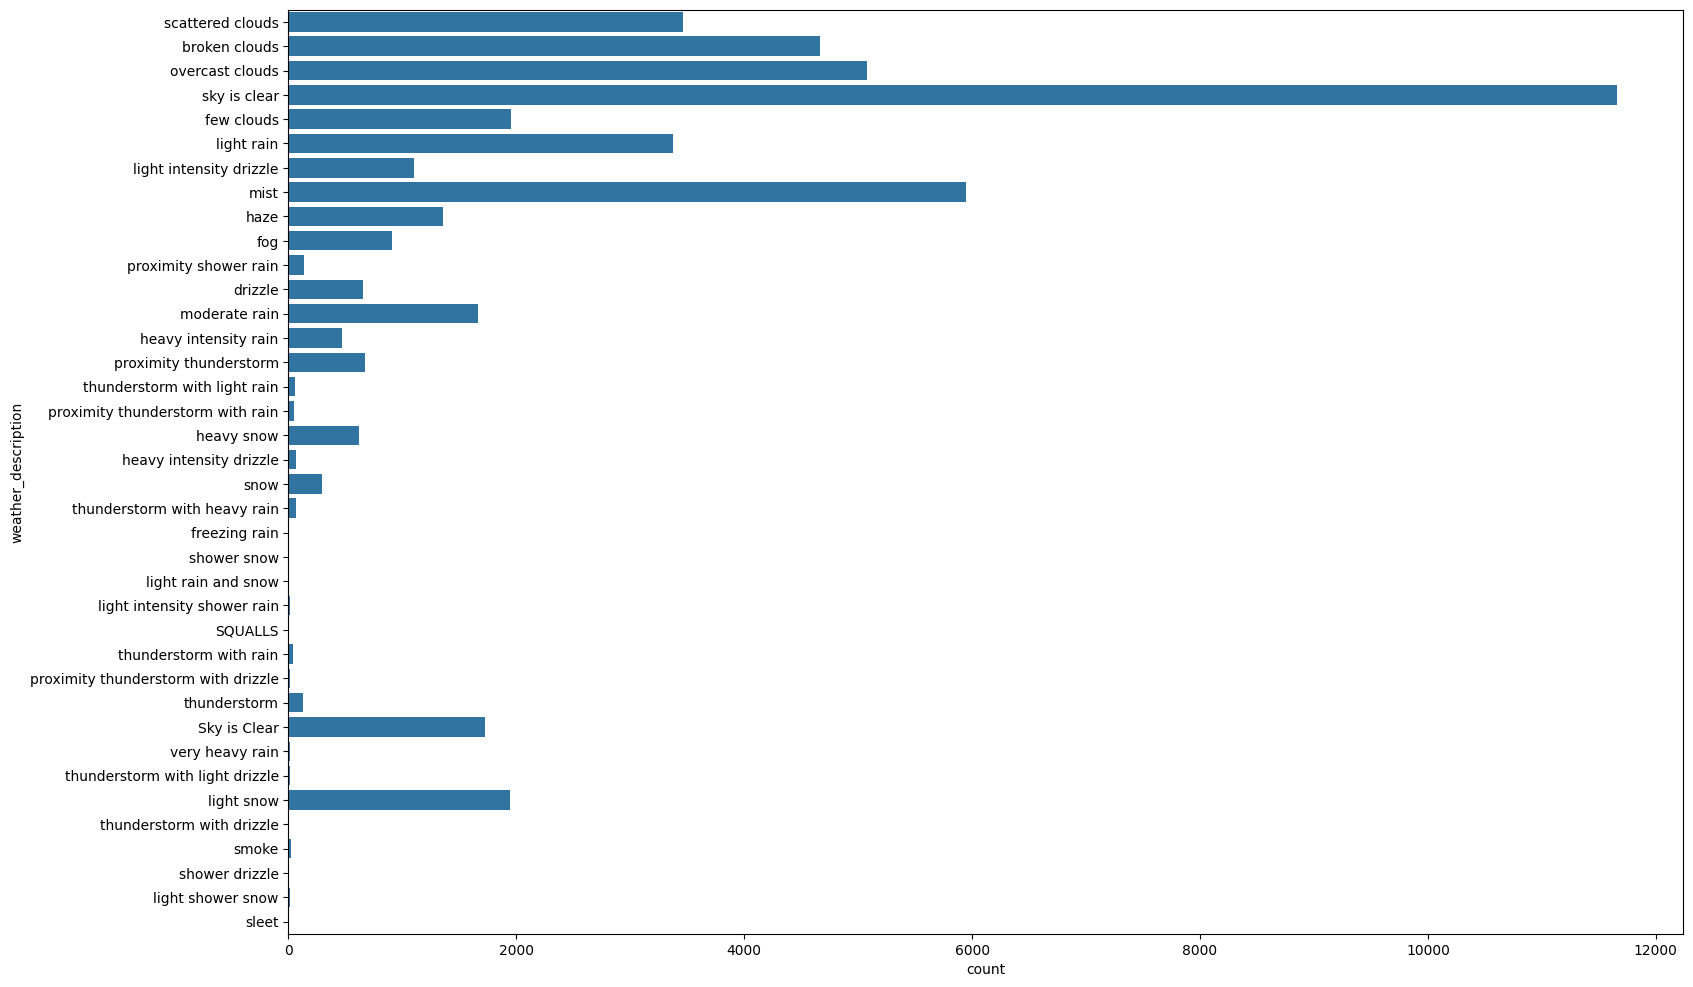

In [24]:
# plotting the frequency of weather_description values
plt.figure(figsize=(18,12))
sns.countplot(y='weather_description',data=df)

Indeed, "weather_description" carries approximately the same information with "weather_main" feature.
Thus, we will remove "weather_description" column.

In our dataset, temperature values in "temp" column is given in Kelvin. For simplicity, i will convert it to Celcius.

In [25]:
df['temp']=df['temp']-273

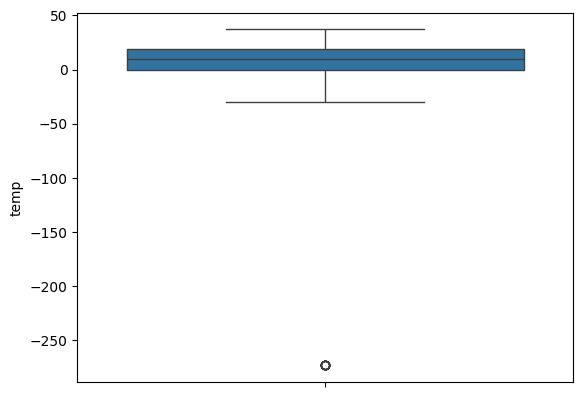

In [26]:
sns.boxplot(df['temp'])
plt.show()

As shown in boxplot above, there is an anomaly. Temperature less than -250 Celcius is not possible. Let's remove an outlier.

In [27]:
# define function to remove outliers
def remove_outlier(df,x):
    Q3,Q1 = np.percentile(df,[75,25])
    IQR = Q3 - Q1
    # Upper bound
    upper = np.where(df >= (Q3+1.5*IQR))
    # Lower bound
    lower = np.where(df <= (Q1-1.5*IQR))

    #Removing the Outliers
    x.drop(upper[0], inplace = True)
    x.drop(lower[0], inplace = True)

remove_outlier(df['temp'],df)

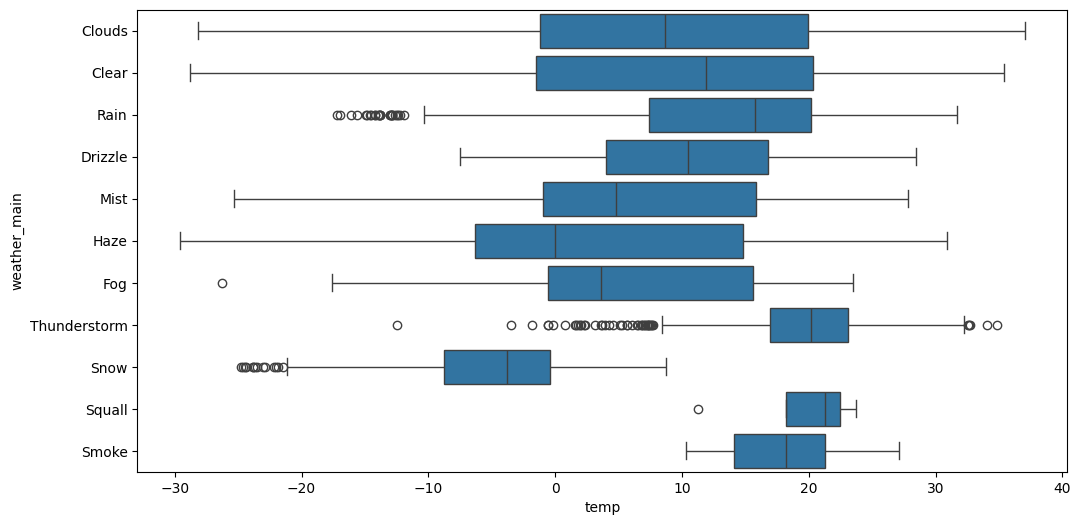

In [28]:
plt.figure(figsize=(12,6))
sns.boxplot(x='temp', y = 'weather_main', data = df)
plt.show()

### Distribution of numerical values

<Axes: xlabel='rain_1h', ylabel='Density'>

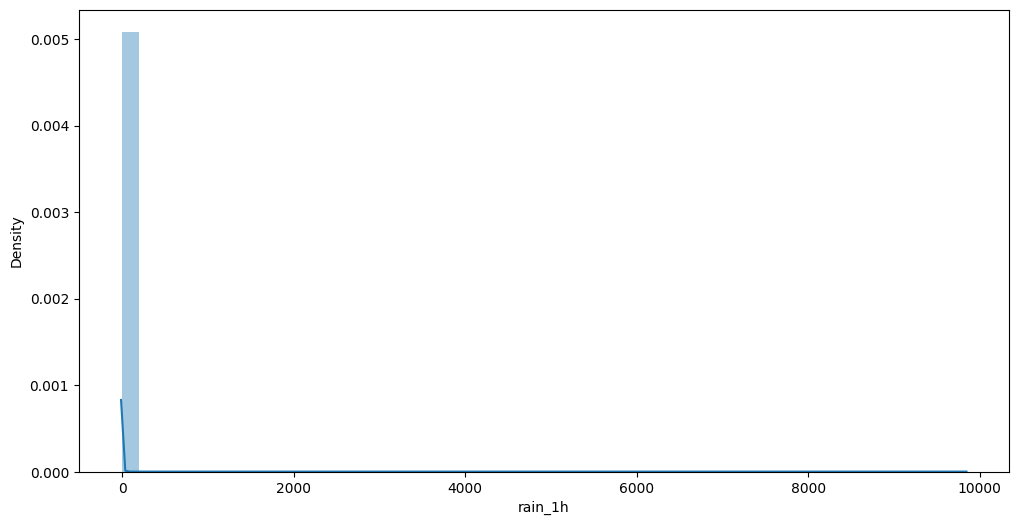

In [29]:
plt.figure(figsize=(12,6))
sns.distplot(df['rain_1h'])

<Axes: xlabel='snow_1h', ylabel='Density'>

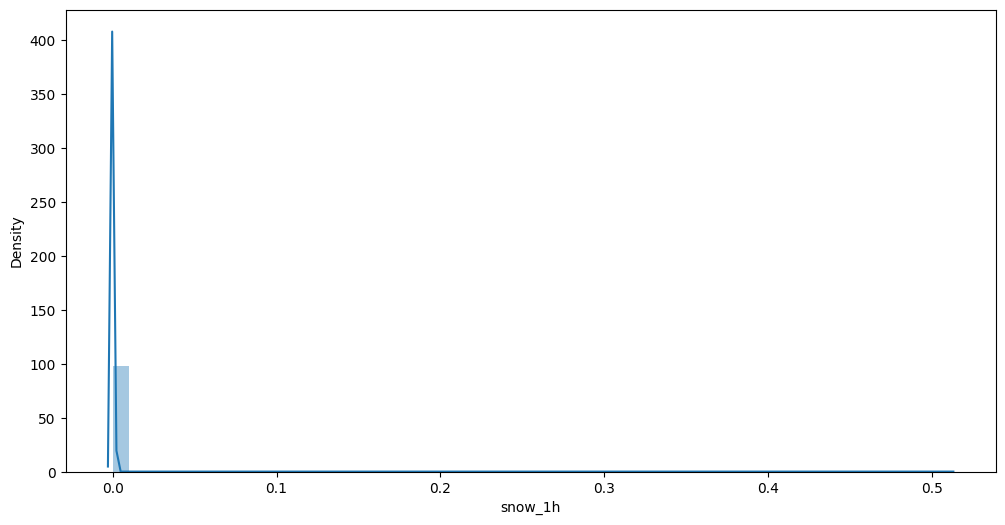

In [30]:
plt.figure(figsize=(12,6))
sns.distplot(df['snow_1h'])

Both of them are highly skewed. Most of values are close to 0.

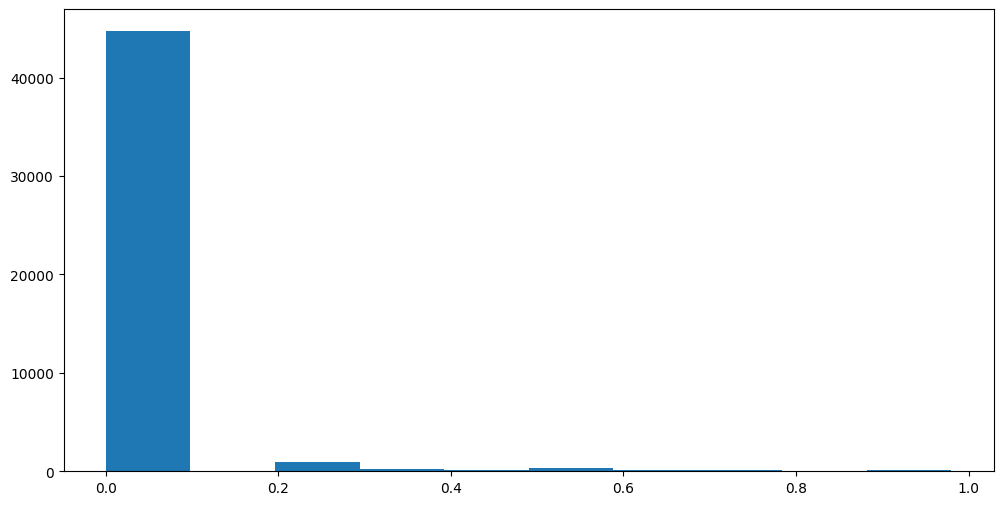

In [31]:
plt.figure(figsize=(12,6))
plt.hist(df.rain_1h.loc[df.rain_1h<1])
plt.show()

In [32]:
df['clouds_all'].min(),df['clouds_all'].max()

(0, 100)

<Axes: xlabel='clouds_all', ylabel='Density'>

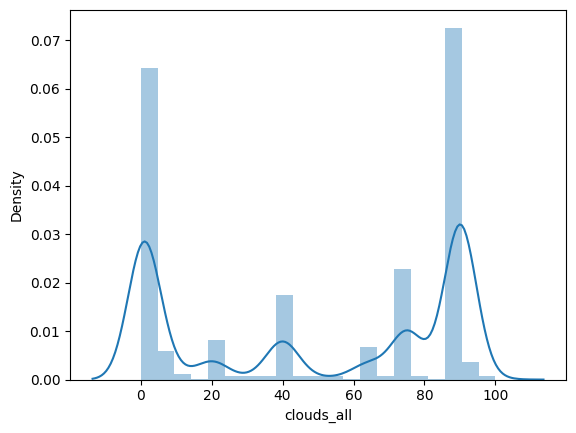

In [33]:
sns.distplot(df['clouds_all'],kde=True)

<Axes: xlabel='temp', ylabel='Density'>

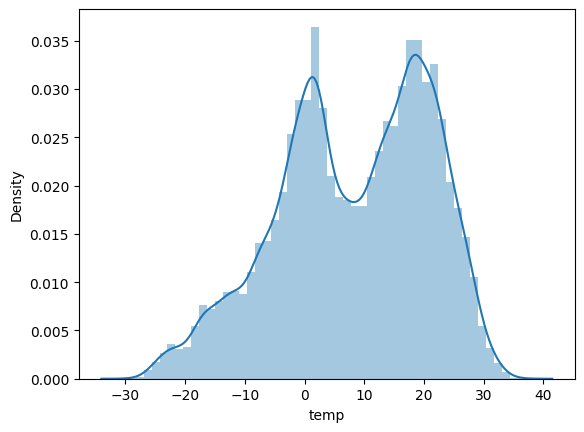

In [34]:
sns.distplot(df['temp'],kde=True)

In [35]:
cols = ['clouds_all','rain_1h','snow_1h','temp']
for i in cols:
    print("Skewness of " + i, df[i].skew())

Skewness of clouds_all -0.19783174381339638
Skewness of rain_1h 219.3275866782041
Skewness of snow_1h 48.35392179428292
Skewness of temp -0.363990535286776


* **clouds all** - the distribution is fairly symmetrical
* **temp** - the distribution is fairly symmetrical
* **rain_1h** - a highly skewed distribution.
* **snow_1h** - a highly skewed distribution.

# Bivariate analysis

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Clouds'),
  Text(1, 0, 'Clear'),
  Text(2, 0, 'Rain'),
  Text(3, 0, 'Drizzle'),
  Text(4, 0, 'Mist'),
  Text(5, 0, 'Haze'),
  Text(6, 0, 'Fog'),
  Text(7, 0, 'Thunderstorm'),
  Text(8, 0, 'Snow'),
  Text(9, 0, 'Squall'),
  Text(10, 0, 'Smoke')])

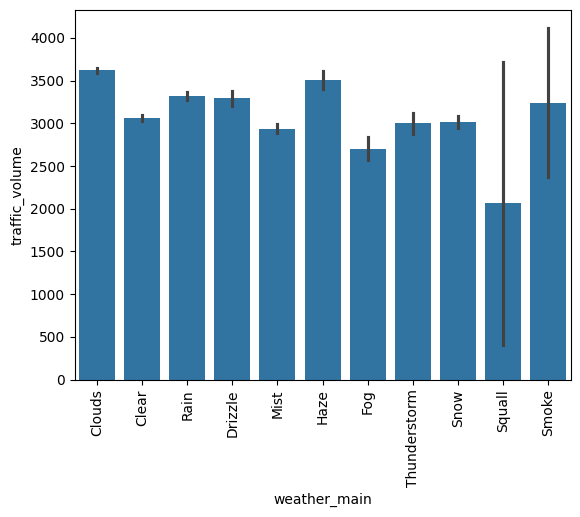

In [36]:
sns.barplot(data = df, x = 'weather_main', y = 'traffic_volume' )
plt.xticks(rotation = 90)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0.0, 0, '0'),
  Text(1000.0, 0, '1000'),
  Text(2000.0, 0, '2000'),
  Text(3000.0, 0, '3000'),
  Text(4000.0, 0, '4000'),
  Text(5000.0, 0, '5000'),
  Text(6000.0, 0, '6000')])

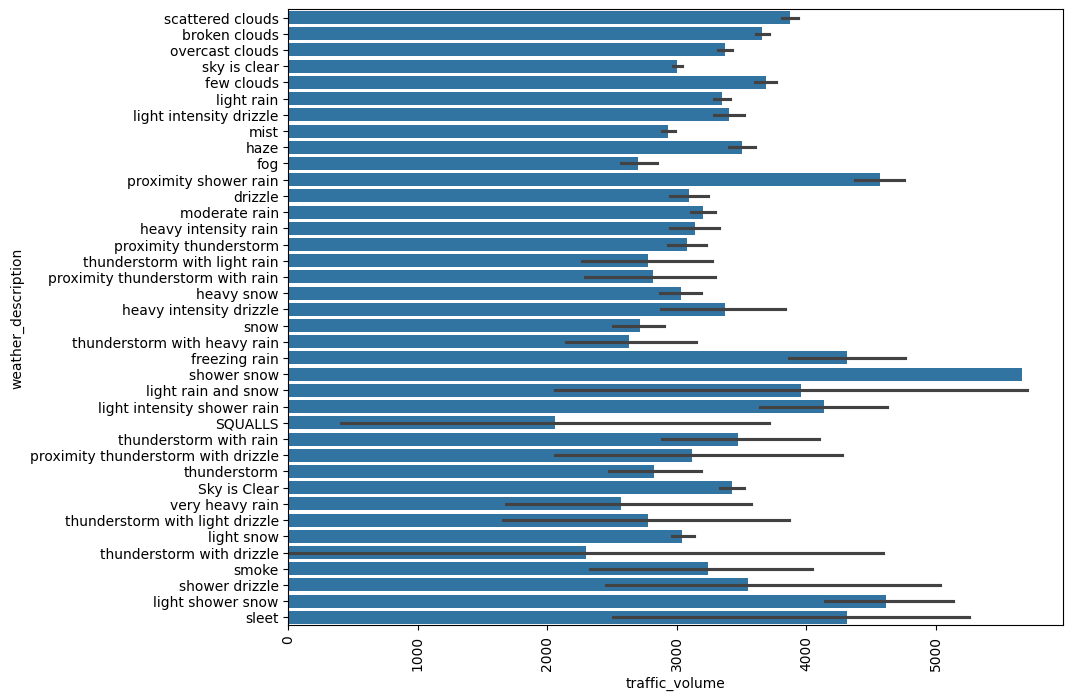

In [37]:
plt.figure(figsize = (10,8))
sns.barplot(data = df, y = 'weather_description', x = 'traffic_volume' )
plt.xticks(rotation = 90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Columbus Day'),
  Text(1, 0, 'Veterans Day'),
  Text(2, 0, 'Thanksgiving Day'),
  Text(3, 0, 'Christmas Day'),
  Text(4, 0, 'New Years Day'),
  Text(5, 0, 'Washingtons Birthday'),
  Text(6, 0, 'Memorial Day'),
  Text(7, 0, 'Independence Day'),
  Text(8, 0, 'State Fair'),
  Text(9, 0, 'Labor Day'),
  Text(10, 0, 'Martin Luther King Jr Day')])

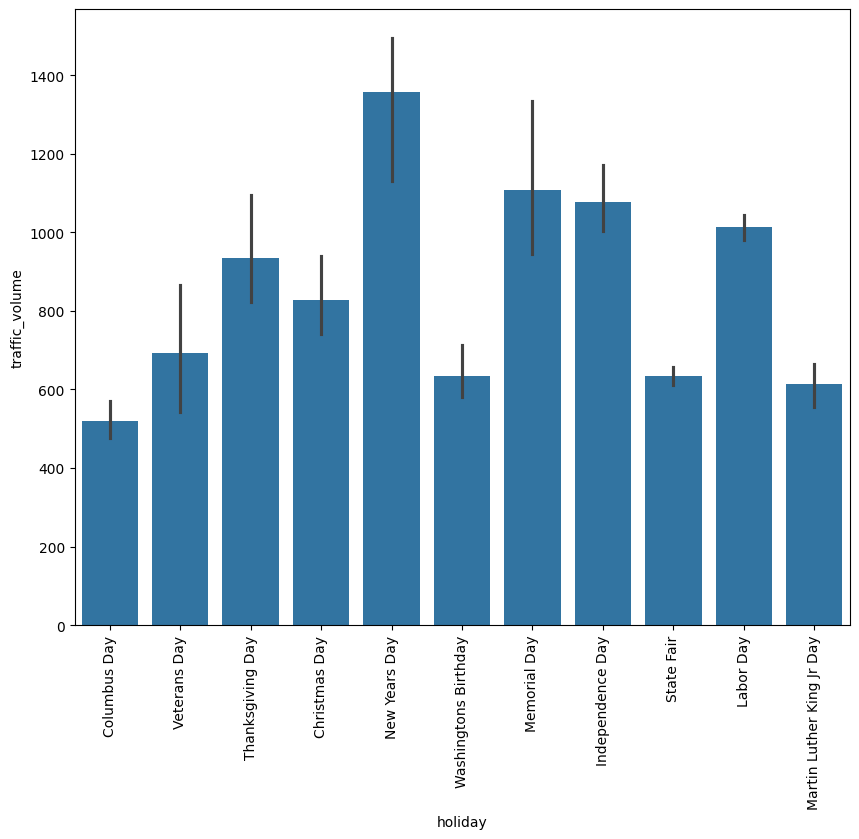

In [38]:
plt.figure(figsize = (10,8))
sns.barplot(x = 'holiday', y = 'traffic_volume', data = df)
plt.xticks(rotation = 90)

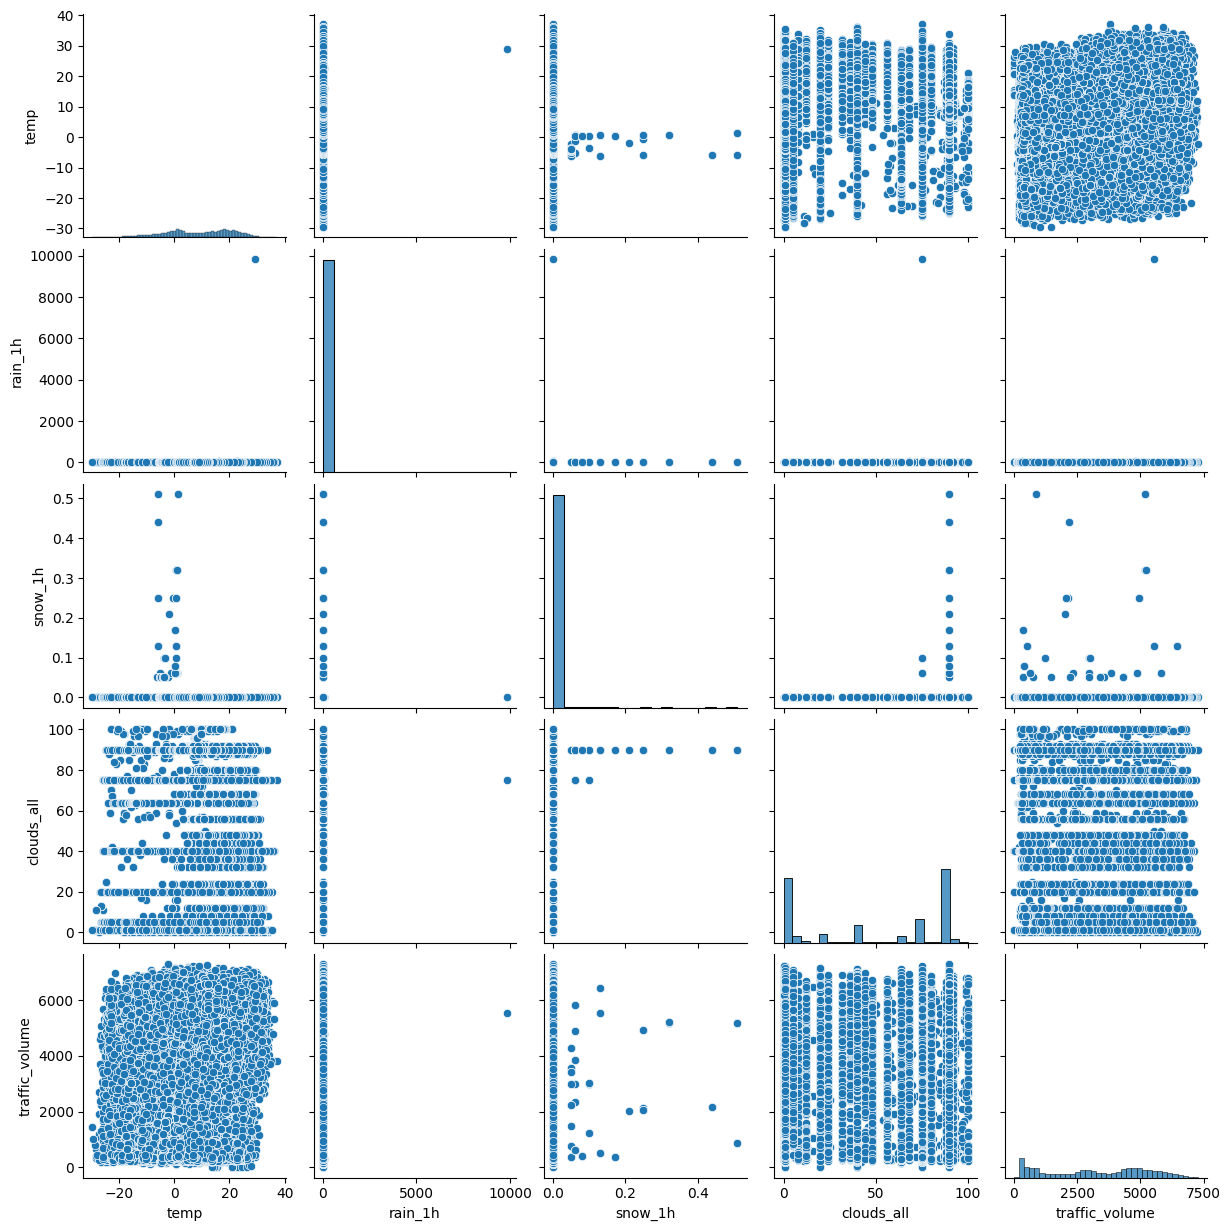

In [39]:
sns.pairplot(df)

# Feature Engineering

In [40]:
data = df.copy()
# create new columns from date_time
data['weekday'] = data.date_time.dt.weekday
data['hour'] = data.date_time.dt.hour
data['month'] = data.date_time.dt.month
data['year'] = data.date_time.dt.year
#Monday is 0 and Sunday is 6

In [41]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,...,traffic_volume,weekday,hour,month,year
0,NaN,15.28,0.0,0.0,40,...,5545,1,9,10,2012
1,NaN,16.36,0.0,0.0,75,...,4516,1,10,10,2012
2,NaN,16.58,0.0,0.0,90,...,4767,1,11,10,2012
3,NaN,17.13,0.0,0.0,90,...,5026,1,12,10,2012
4,NaN,18.14,0.0,0.0,75,...,4918,1,13,10,2012


<Axes: xlabel='weekday', ylabel='traffic_volume'>

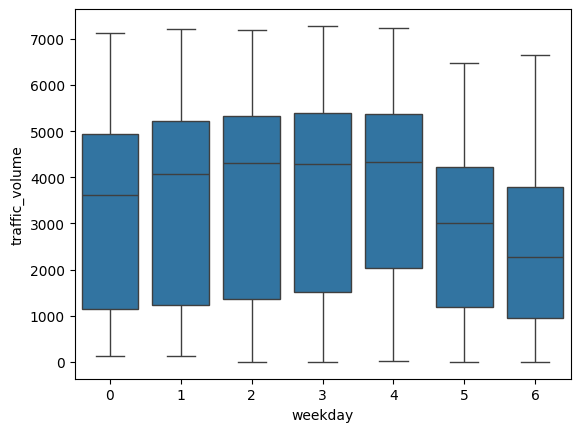

In [42]:
sns.boxplot(x = 'weekday', y = 'traffic_volume', data = data)

In [43]:
def hour_modify(x):
    Early_Morning = [4,5,6,7]
    Morning = [8,9,10,11]
    Afternoon = [12,13,14,15]
    Evening = [16,17,18,19]
    Night = [20,21,22,23]
    Late_Night = [24,1,2,3]
    if x in Early_Morning:
        return 'Early Morning'
    elif x in Morning:
        return 'Morning'
    elif x in Afternoon:
        return 'Afternoon'
    elif x in Evening:
        return 'Evening'
    elif x in Night:
        return 'Night'
    else:
        return 'Late Night'

data['hour'] = data.hour.apply(hour_modify)

In [44]:
def modify_holiday(x):
    if x == 'None':
        return False
    else:
        return True

data['holiday'] = data['holiday'].apply(modify_holiday)

In [45]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,...,traffic_volume,weekday,hour,month,year
0,True,15.28,0.0,0.0,40,...,5545,1,Morning,10,2012
1,True,16.36,0.0,0.0,75,...,4516,1,Morning,10,2012
2,True,16.58,0.0,0.0,90,...,4767,1,Morning,10,2012
3,True,17.13,0.0,0.0,90,...,5026,1,Afternoon,10,2012
4,True,18.14,0.0,0.0,75,...,4918,1,Afternoon,10,2012
...,...,...,...,...,...,...,...,...,...,...,...
48199,True,10.45,0.0,0.0,75,...,3543,6,Evening,9,2018
48200,True,9.76,0.0,0.0,90,...,2781,6,Night,9,2018
48201,True,9.73,0.0,0.0,90,...,2159,6,Night,9,2018
48202,True,9.09,0.0,0.0,90,...,1450,6,Night,9,2018


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Morning'),
  Text(1, 0, 'Afternoon'),
  Text(2, 0, 'Evening'),
  Text(3, 0, 'Night'),
  Text(4, 0, 'Late Night'),
  Text(5, 0, 'Early Morning')])

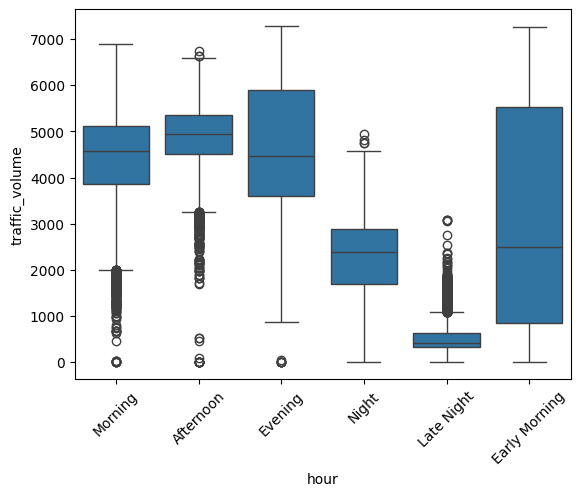

In [46]:
sns.boxplot(x = 'hour', y = 'traffic_volume', data = data)
plt.xticks(rotation = 45)

**At night** and **late night** there is less traffic.

In [47]:
data[['month','weekday']] = data[['month','weekday']] .astype('category')

In [48]:
data.dtypes

holiday                          bool
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
weekday                      category
hour                           object
month                        category
year                            int32
dtype: object

In [49]:
# remove 'weather_description', 'year' column
data.drop(['weather_description','year'], axis=1, inplace=True)

In [50]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,...,date_time,traffic_volume,weekday,hour,month
0,True,15.28,0.0,0.0,40,...,2012-10-02 09:00:00,5545,1,Morning,10
1,True,16.36,0.0,0.0,75,...,2012-10-02 10:00:00,4516,1,Morning,10
2,True,16.58,0.0,0.0,90,...,2012-10-02 11:00:00,4767,1,Morning,10
3,True,17.13,0.0,0.0,90,...,2012-10-02 12:00:00,5026,1,Afternoon,10
4,True,18.14,0.0,0.0,75,...,2012-10-02 13:00:00,4918,1,Afternoon,10


We will remove 'snow_1h' and 'rain_1h' features as most of their values are 0.

In [51]:
data.drop(['snow_1h','rain_1h'],inplace=True,axis=1)

In [52]:
data['traffic_volume'].skew()

-0.08932776841234133

**'traffic_volume'** has a skewness value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

In [53]:
data.set_index('date_time',inplace=True)

In [54]:
data.head()

,holiday,temp,clouds_all,weather_main,traffic_volume,weekday,hour,month
date_time,,,,,,,,
2012-10-02 09:00:00,True,15.28,40,Clouds,5545,1,Morning,10
2012-10-02 10:00:00,True,16.36,75,Clouds,4516,1,Morning,10
2012-10-02 11:00:00,True,16.58,90,Clouds,4767,1,Morning,10
2012-10-02 12:00:00,True,17.13,90,Clouds,5026,1,Afternoon,10
2012-10-02 13:00:00,True,18.14,75,Clouds,4918,1,Afternoon,10


In [55]:
# Define dependent and independent variables
X = data.drop('traffic_volume', axis=1)
y = data['traffic_volume']

In [56]:
X

,holiday,temp,clouds_all,weather_main,weekday,hour,month
date_time,,,,,,,
2012-10-02 09:00:00,True,15.28,40,Clouds,1,Morning,10
2012-10-02 10:00:00,True,16.36,75,Clouds,1,Morning,10
2012-10-02 11:00:00,True,16.58,90,Clouds,1,Morning,10
2012-10-02 12:00:00,True,17.13,90,Clouds,1,Afternoon,10
2012-10-02 13:00:00,True,18.14,75,Clouds,1,Afternoon,10
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,True,10.45,75,Clouds,6,Evening,9
2018-09-30 20:00:00,True,9.76,90,Clouds,6,Night,9
2018-09-30 21:00:00,True,9.73,90,Thunderstorm,6,Night,9


In [57]:
X['hour'].unique()

array(['Morning', 'Afternoon', 'Evening', 'Night', 'Late Night',
       'Early Morning'], dtype=object)

# Train test splitting

In [58]:
# Divide data into training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=101)

# Implementation of different models

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_vars = ['temp','clouds_all']
cat_vars = ['holiday','weather_main', 'weekday', 'hour', 'month']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('encoder',OrdinalEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])


In [60]:
models = [AdaBoostRegressor(), GradientBoostingRegressor(), RandomForestRegressor(),
         CatBoostRegressor(), XGBRegressor()]

model_labels = ['AdaBoost','GradientBoost','RandomForest','CatBoost','XGBoost']
r2_scores = []

for model in models:
    data_pipeline = Pipeline(steps = [
                                    ('preprocessor', preprocessor),
                                    ('model', model)])

    r2_score = cross_val_score(data_pipeline, X_train, y_train, cv=KFold(n_splits=10), scoring='r2',n_jobs=-1).mean()
    r2_scores.append(r2_score)


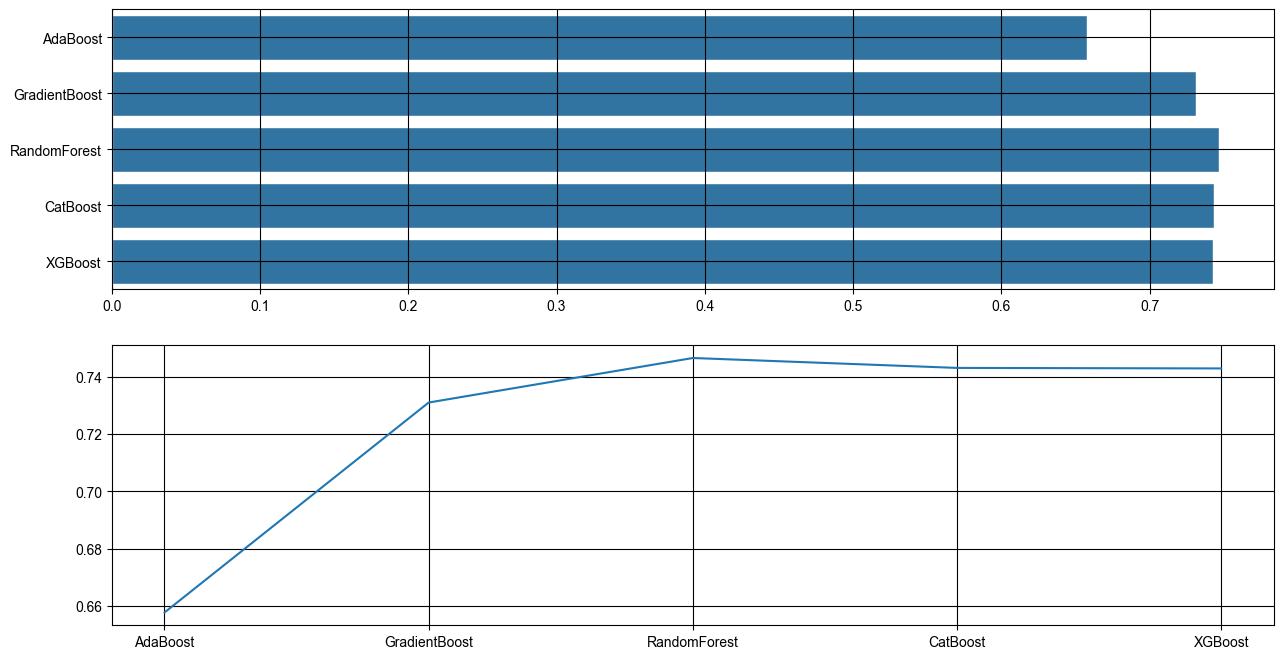

In [61]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15,8))

sns.set_style('dark')
sns.barplot(y = model_labels ,x = r2_scores, ax=axes[0])
axes[0].grid(True, color='k')

sns.set_style('whitegrid')
sns.lineplot(x = model_labels, y = r2_scores)
axes[1].grid(True, color='k')
fig.show()


In [62]:
results = zip(model_labels,r2_scores)
print(list(results))

[('AdaBoost', 0.6577084430417452), ('GradientBoost', 0.7309513143403221), ('RandomForest', 0.7464832177343238), ('CatBoost', 0.7430278787641243), ('XGBoost', 0.7428453266620636)]


**CatBoostRegressor** has high R2 score! Let's optimize our model with GridSearch and Cross Validation.

# Optimization by using GridSearch and Cross Validation

In [63]:
data_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                  ('model', CatBoostRegressor(random_state=42))])

In [64]:
rf_grid= {'model__depth':[6,8],
    'model__learning_rate':[0.1,0.5,0.3],
    'model__iterations':[100],
          'model__min_data_in_leaf':[500,700]
}

grid_search = GridSearchCV(data_pipeline,param_grid=rf_grid,n_jobs=-1,cv=KFold(n_splits=3))

grid_search.fit(X_train,y_train)

0:	learn: 1583.2472557	total: 165ms	remaining: 16.3s
1:	learn: 1340.8686599	total: 179ms	remaining: 8.76s
2:	learn: 1209.3244306	total: 196ms	remaining: 6.32s
3:	learn: 1136.5176790	total: 212ms	remaining: 5.08s
4:	learn: 1092.4972833	total: 228ms	remaining: 4.33s
5:	learn: 1071.0522244	total: 244ms	remaining: 3.82s
6:	learn: 1058.6548368	total: 260ms	remaining: 3.45s
7:	learn: 1048.7111756	total: 276ms	remaining: 3.17s
8:	learn: 1043.8471816	total: 293ms	remaining: 2.96s
9:	learn: 1039.7453621	total: 313ms	remaining: 2.82s
10:	learn: 1035.9548406	total: 335ms	remaining: 2.71s
11:	learn: 1032.6064039	total: 353ms	remaining: 2.59s
12:	learn: 1030.6454012	total: 363ms	remaining: 2.43s
13:	learn: 1029.0647008	total: 373ms	remaining: 2.29s
14:	learn: 1027.6840520	total: 380ms	remaining: 2.15s
15:	learn: 1026.1434143	total: 389ms	remaining: 2.04s
16:	learn: 1024.6429227	total: 396ms	remaining: 1.93s
17:	learn: 1023.3161013	total: 405ms	remaining: 1.84s
18:	learn: 1021.6885691	total: 412ms	r

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'clouds_all']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['holiday',
                                                                          'weather_main',
                                                                          'weekday',
                                                                          'hour',
                                                                          'month'])])),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x000001D5ECC00380>)]),
             n_jobs=-1,
             param_grid={'model__depth': [6, 8], 'model__iterations': [100],
                         'model__learning_rate': [0.1, 0.5, 0.3],
                         'model__min_data_in_leaf': [500, 700]})

#### This will try out 4 * 3 * 3 * 3 * 2 * 1 = 216 combinations of settings. We can display the best parameters, and evaluate performance:

In [65]:
grid_search.best_params_

{'model__depth': 6,
 'model__iterations': 100,
 'model__learning_rate': 0.3,
 'model__min_data_in_leaf': 500}

In [66]:
pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                  ('model', CatBoostRegressor(iterations=100,
                                                              depth=8,
                                                              learning_rate=0.1,
                                                             loss_function='RMSE',
                                                             random_seed=29,
                                                             bagging_temperature=0.95,
                                                             min_data_in_leaf=500))])
r2_scores = cross_val_score(pipeline, X_train, y_train, cv=KFold(n_splits=5), scoring='r2',n_jobs=-1)
print('max r2 :', r2_scores.max())
print('min r2 :', r2_scores.min())
print('mean r2 :', r2_scores.mean())

max r2 : 0.7481684643281352
min r2 : 0.7344275551057946
mean r2 : 0.7395713512828582


# Model Testing

In [67]:
pipeline.fit(X_train, y_train)
y_pred=pipeline.predict(X_test)

0:	learn: 1847.6022298	total: 13.7ms	remaining: 1.36s
1:	learn: 1725.4550209	total: 22.7ms	remaining: 1.11s
2:	learn: 1619.2875311	total: 35ms	remaining: 1.13s
3:	learn: 1526.6081671	total: 47.1ms	remaining: 1.13s
4:	learn: 1448.4576676	total: 58ms	remaining: 1.1s
5:	learn: 1381.6804795	total: 70.6ms	remaining: 1.11s
6:	learn: 1323.5909088	total: 82.8ms	remaining: 1.1s
7:	learn: 1275.3467982	total: 95.1ms	remaining: 1.09s
8:	learn: 1234.8618130	total: 107ms	remaining: 1.08s
9:	learn: 1200.2870552	total: 118ms	remaining: 1.06s
10:	learn: 1171.3762088	total: 130ms	remaining: 1.05s
11:	learn: 1147.3982743	total: 143ms	remaining: 1.05s
12:	learn: 1126.8485231	total: 156ms	remaining: 1.04s
13:	learn: 1110.6900757	total: 169ms	remaining: 1.03s
14:	learn: 1097.5002752	total: 180ms	remaining: 1.02s
15:	learn: 1086.2363403	total: 192ms	remaining: 1.01s
16:	learn: 1076.5678924	total: 204ms	remaining: 996ms
17:	learn: 1068.5345306	total: 216ms	remaining: 985ms
18:	learn: 1062.1459654	total: 230ms

In [68]:
mean_absolute_error(y_test,y_pred)

727.3928318747587

In [69]:
np.sqrt(mean_absolute_error(y_test,y_pred))

26.970221205521447

In [70]:
y_pred

array([5344.72632014, 2628.79161221, 4787.30446874, ..., 3802.01008086,
       4633.14381744, 5073.87615515])

# Exporting model

In [71]:
document = "mypickle.pkl"

pickle.dump(pipeline,open(document,"wb"))